# Nested cross-validation

Take a subset of observables and frames as a test set and "train" the model on the remaining set (namely, determine the optimal hyperparameters, as described in the previous notebooks, and then minimize the loss function at the optimal hyperparameters) - external splitting. Then, compute the $\chi^2$ on the test set at the optimal solution found by `MDRefinement` on the (external) training set.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [1]:
import sys, time, datetime
import numpy as np
# import pandas
# import matplotlib.pyplot as plt
import jax.numpy as jnp
import pandas

In [2]:
# import from parent directory
import sys
sys.path.insert(0, '../')

import MDRefine

print("I will use the MDRefine version installed at", MDRefine.__file__)

from MDRefine import load_data, split_dataset, MDRefinement, compute_chi2_test

I will use the MDRefine version installed at ../MDRefine/__init__.py


## Python cells to do nested cross-validation

### Load data

In [3]:
%%bash

if [ ! -d "DATA" ]; then
    curl -O https://zenodo.org/records/14956459/files/DATA.zip

    unzip DATA.zip
    rm -r DATA.zip
fi

In [4]:
# %% input values

stride = 10

# inverse starting hyperparameters, determining the refinement
# 0 for no refinement (infinite hyperpars), 1 otherwise (for example)
inv_starting_alpha = 1
inv_starting_beta = 1
inv_starting_gamma = 0

test_seed = 1  # -1 for no test set

In [5]:
system_names = ['AAAA', 'CAAU']  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC']
random_states = [1,2]  # [1,2,3,4,5]

In [6]:
results_folder_name = '6_Result'
id_code = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
# the folder with output results is: results_folder_name + '_' + id_code

# %%
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

'''
system_name/ff_terms.npy have columns:
sinalpha[0],sinalpha[1],sinalpha[2],sinzeta[0],sinzeta[1],sinzeta[2],cosalpha[0],cosalpha[1],cosalpha[2],coszeta[0],coszeta[1],coszeta[2]
(n. of angles up to n. of residues -1, namely 3 for tetramers and 5 for hexamers)
'''
def ff_correction_tetramers(pars, f):
    # sin alpha, cos alpha, sin zeta, cos zeta:
    # out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)

    # sin alpha, cos alpha
    out = jnp.matmul(pars, (f[:,[0,6]]+f[:,[1,7]]+f[:,[2,8]]).T)
    
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10]]+f[:,[1,11]]+f[:,[2,12]]+f[:,[3,13]]+f[:,[4,14]]).T)
    return out

infos = {}

infos['global'] = {
    'path_directory': 'DATA',
    'system_names': system_names,
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs','<')],
    'obs' : ['NOEs', 'uNOEs'],
    'forward_qs':  ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
    'temperature': 1,  # namely, energies are in unit of k_B T (default value)
    'forward_coeffs': 'original_fm_coeffs',
    'forward_model': forward_model_fun,
    'ff_correction': ff_correction_tetramers,
    'names_ff_pars': ['sin alpha', 'cos alpha']}  # , 'sin zeta', 'cos zeta']}

infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

# %%
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

#%% 2. split dataset into training (used by MDRefinement and/or minimizer) and test

time1 = time.time()

data = load_data(infos, stride=stride)

print(data.mol['AAAA'].weights.shape)

loading data from directory...
loading  AAAA
loading  CAAU
done
(1017,)


split the dataset into training and test set (external splitting)

In [7]:
if not(test_seed == -1): 
    data_training, data_test, test_obs, test_frames = split_dataset(data, frames_fraction=0.1, obs_fraction=0.1, random_state=test_seed)
else:
    data_training = data

# print('test obs: ', test_obs)

# mini = hyper_minimizer(data_training, regularization=regularization, starting_alpha=1e-1, starting_gamma=1e-1, random_states=[1], which_set='training')

def inverse(inv_hyperpar):
    if inv_hyperpar == 0:
        hyperpar = np.inf
    else:
        hyperpar = 1/inv_hyperpar
    return hyperpar

starting_alpha = inverse(inv_starting_alpha)
starting_beta = inverse(inv_starting_beta)
starting_gamma = inverse(inv_starting_gamma)

Input random_state employed both for observables and frames


apply `MDRefinement` on the (external) training set

In [8]:
Result = MDRefinement(data_training, regularization=regularization, stride=stride, starting_alpha=starting_alpha,
    starting_beta=starting_beta, starting_gamma=starting_gamma, random_states=random_states, which_set='validation',
    results_folder_name=results_folder_name, id_code=id_code, n_parallel_jobs=4)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [9]:
if not (test_seed == -1):
    if np.isinf(starting_beta): pars_ff = None
    else: pars_ff = Result.pars[:2]

    if np.isinf(starting_gamma): pars_fm = None
    else: pars_fm = Result.pars[-9:]

    if hasattr(Result, 'min_lambdas'): lambdas = Result.min_lambdas
    else: lambdas = None

In [10]:
if not (test_seed == -1):
    ref_test_chi2 = compute_chi2_test(data_test, regularization)
    test_chi2 = compute_chi2_test(data_test, regularization, pars_ff, pars_fm, lambdas)

all the hyperparameters are infinite


In [11]:
if pars_ff is None:
    log10_beta = np.inf
    pars = []
else:
    log10_beta = 0
    pars = pars_ff

if pars_fm is None: log10_gamma = np.inf
else:
    log10_gamma = 0
    pars = np.concatenate((pars, pars_fm))

In [12]:
dtime = time.time() - time1

with open(results_folder_name + '_' + id_code + '/out.txt', 'w') as f:
    print('time required: ', dtime, file=f)
    if not (test_seed == -1):
        print('reference test chi2: ', ref_test_chi2, file=f)
        print('test chi2: ', test_chi2, file=f)
    
    if (test_seed == -1): print('whole set', file=f)
    else: print(test_seed, file=f)
    
    print(vars(Result), file=f)

if not (test_seed == -1):
    with open(results_folder_name + '_' + id_code + '/test_obs.txt', 'w') as f:
        print(test_obs, file=f)

In [13]:
dict_chi2 = {}

dict_chi2['time'] = dtime
dict_chi2['test seed'] = test_seed

if not (test_seed == -1):
    dict_chi2['ref. test chi2'] = ref_test_chi2
    dict_chi2['test chi2'] = test_chi2

In [14]:
data_train_inn, data_valid, _, _ = split_dataset(data_training)
# reduced chi2 for reference ensemble at random data_valid
dict_chi2['ref. validation chi2'] = compute_chi2_test(data_valid, regularization)

df = pandas.read_csv('6_Result_%s/hyper_search' % id_code, index_col=0)
n_valid_obs = 0.2*data_training.properties.tot_n_experiments(data_training)

dict_chi2['validation chi2'] = df['av_chi2'].iloc[-1]/n_valid_obs

random state:  496
Input random_state employed both for observables and frames
all the hyperparameters are infinite


In [15]:
dict_chi2

{'time': 5326.4278218746185,
 'test seed': 1,
 'ref. test chi2': DeviceArray(1118.5914999, dtype=float64),
 'test chi2': DeviceArray(3.55906368, dtype=float64),
 'ref. validation chi2': DeviceArray(599.19331001, dtype=float64),
 'validation chi2': 6.451346501631832}

### plot results

In [16]:
import matplotlib.pyplot as plt

#### only alpha, beta are finite

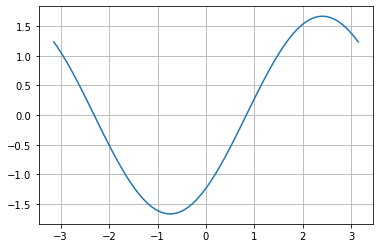

In [17]:
phi = np.linspace(-np.pi, np.pi, 100)

ff = pars_ff[0]*np.sin(phi) + pars_ff[1]*np.cos(phi)

plt.plot(phi, ff)
plt.grid()

#### alpha, beta, gamma finite

In [18]:
pars_ff = [0.47, -0.69]

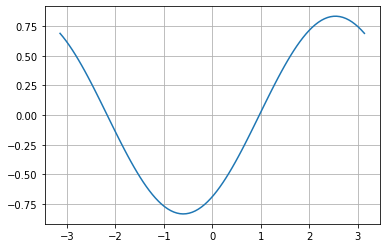

In [19]:
phi = np.linspace(-np.pi, np.pi, 100)

ff = pars_ff[0]*np.sin(phi) + pars_ff[1]*np.cos(phi)

plt.plot(phi, ff)
plt.grid()

In [20]:
def karplus_eqs(abc_vec, label):
    a = abc_vec[0]
    b = abc_vec[1]
    c = abc_vec[2]
    
    phi = np.linspace(-np.pi, np.pi, 100)
    jcoupl = a*np.cos(phi)**2 + b*np.cos(phi) + c
    plt.plot(phi, jcoupl, label=label)
    return jcoupl

In [21]:
pars_fm = [10.004597324896954,-1.8485215697269826,-0.09784818743664454,17.661008908704908,-5.620509738472044,0.3666656352130098,8.313714052123622,-1.747608179308823,0.07022860454362531]


In [22]:
pars_fm = [10.11932004706091,-1.8353743442277473,-0.15889622628224842,18.46473060154171,-5.407652128177933,-0.0010797721325949815,8.302189107903807,-1.8122958419840105,-0.027826707440357056]

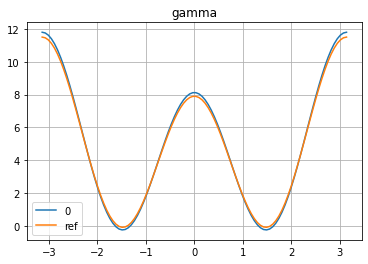

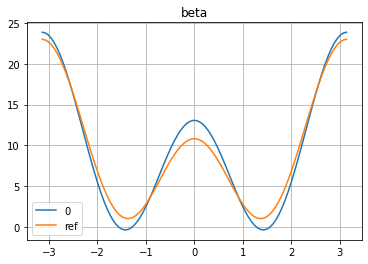

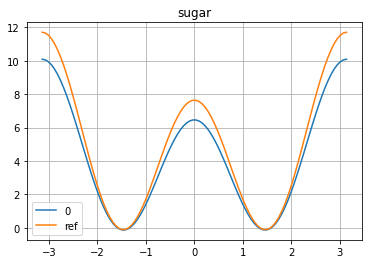

In [23]:
out = karplus_eqs(pars_fm[:3], '0')
out = karplus_eqs([9.7, -1.8, 0.0], 'ref')
plt.title('gamma')
plt.grid()
plt.legend()

plt.figure()
out = karplus_eqs(pars_fm[3:6], '0')
out = karplus_eqs([15.3, -6.1, 1.6], 'ref')
plt.title('beta')
plt.grid()
plt.legend()

plt.figure()
out = karplus_eqs(pars_fm[6:], '0')
out = karplus_eqs([9.67, -2.03, 0.], 'ref')
plt.title('sugar')
plt.legend()
plt.grid()

## Analysis of the results
from computations on cluster

In [24]:
import os
import matplotlib
import matplotlib.pyplot as plt

In [25]:
path = 'Results/'
dir_list = os.listdir(path)
dir_list = [s for s in dir_list if s.startswith('6_Result')]

temp = []

for s in dir_list:
    df = pandas.read_csv(path + s + '/input', index_col=0)
    df2 = pandas.read_csv(path + s + '/result', index_col=0)
    if 'time' in df2.columns: del df2['time']

    path_chi2 = path + s + '/chi2s'
    if os.path.exists(path_chi2): df3 = pandas.read_csv(path_chi2, index_col=0)
    else: df3 = pandas.DataFrame({'temp': [np.nan]})
    df3.index = df2.index

    df = pandas.concat([df, df2, df3], axis=1)
    df['stride'] = 10**np.int(6 - np.round(np.log10(np.load(path + s + '/weights_new_AAAA.npy').shape[0])))
    temp.append(df)

df_result_nested = pandas.concat(temp, axis=0, ignore_index=False)
try: del df_result_nested['temp']
except: None

df_result_nested

,starting_alpha,starting_beta,starting_gamma,random_states,which_set,gtol,ftol,loss,A_gamma,B_gamma,...,stride,sin alpha,cos alpha,reg_ff_AAAA,reg_ff_CAAU,reg_ff_CCCC,reg_ff_GACC,reg_ff_UUUU,reg_ff_UCAAUC,optimal beta
2025_03_26_00_37_48,1.0,inf,1.0,"[1, 2, 3, 4, 5]",validation,0.5,0.05,194.709834,10.468450,-1.844714,...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_03_26_03_45_28,1.0,1.0,1.0,"[1, 2, 3, 4, 5]",validation,0.5,0.05,245.593013,10.301094,-1.745642,...,10,0.608594,-1.140812,0.434984,0.700132,0.615394,0.32307,0.460612,1.121175,1.886105


In [26]:
df_result_nested = df_result_nested.loc[df_result_nested['random_states'] == '[1, 2, 3, 4, 5]']
df_result_nested = df_result_nested.loc[df_result_nested['which_set'] == 'validation']

cols = ['optimal alpha', 'optimal beta', 'optimal gamma', 'stride', 'gtol', 'ftol', 'sin alpha', 'cos alpha', 'A_gamma', 'B_gamma', 'C_gamma',
    'A_beta', 'B_beta', 'C_beta', 'A_sugar', 'B_sugar', 'C_sugar', 'ref. test chi2', 'test chi2',
    'ref. validation chi2', 'validation chi2']

df_result_nested = df_result_nested[cols]
df_result_nested = df_result_nested.loc[~np.isnan(df_result_nested['ref. validation chi2'])]
df_result_nested = df_result_nested.loc[df_result_nested['stride'] == 10]

df_result_nested[['optimal alpha', 'optimal beta', 'optimal gamma', 'ref. test chi2', 'test chi2']]

# df_result_nested = df_result_nested.loc[['2025_03_26_00_37_48', '2025_03_26_03_45_28']]
df_result_nested.index = ['E+FM ref', 'E+FM+FF ref']

df_result_nested

,optimal alpha,optimal beta,optimal gamma,stride,gtol,ftol,sin alpha,cos alpha,A_gamma,B_gamma,...,A_beta,B_beta,C_beta,A_sugar,B_sugar,C_sugar,ref. test chi2,test chi2,ref. validation chi2,validation chi2
E+FM ref,14.774292,NaN,0.521908,10,0.5,0.05,NaN,NaN,10.468450,-1.844714,...,19.589466,-5.120117,-0.540211,8.420553,-1.869369,-0.117869,537.43525,1.620779,245.267645,0.884798
E+FM+FF ref,37.236967,1.886105,0.350607,10,0.5,0.05,0.608594,-1.140812,10.301094,-1.745642,...,18.567138,-5.224371,-0.168163,7.430933,-1.724907,0.421051,537.43525,2.129081,147.789435,1.335130


- if someone among `optimal_alpha`, `optimal_beta`, `optimal_gamma` is `NaN`, it means no refinement in that direction
- if `ref. test chi2` is `NaN` (but `ref. validation chi2` is not), it means there is not the (external) test set

In [27]:
# minimization on the whole dataset

path = 'Results'
my_str = '2_Result_last_'

my_list = ['2024_10_01_13_36_53_483051', '2024_10_03_12_35_46_920644']

# ER+FFR and ER+FFR+FMR
df_result = pandas.concat([
    pandas.read_csv(path + '/' + my_str + my_list[1] + '/' + 'result', index_col=0),  # ER+FMR+FFR
    pandas.read_csv(path + '/' + my_str + my_list[0] + '/' + 'result', index_col=0)  # ER+FMR
    ])

df_result.index = ['E+FM+FF ref', 'E+FM ref']
df_result

,loss,sin alpha,cos alpha,A_gamma,B_gamma,C_gamma,A_beta,B_beta,C_beta,A_sugar,...,chi2_AAAA,chi2_CAAU,chi2_CCCC,chi2_GACC,chi2_UUUU,chi2_UCAAUC,optimal alpha,optimal beta,optimal gamma,hyper_mini success
E+FM+FF ref,1765.300623,0.584072,-0.791454,9.915804,-1.757341,-0.116239,18.128530,-5.288647,0.07166,6.986191,...,120.535372,98.730666,56.247744,31.282016,178.522105,805.854758,959.856495,167.935942,0.421759,True
E+FM ref,381.026229,NaN,NaN,9.950988,-1.858315,-0.107576,18.907471,-5.230515,-0.21221,8.335141,...,43.166862,29.767058,18.449176,19.622261,24.415580,214.539056,46.308959,NaN,0.958824,True


full dataset:  sin alpha    0.584072
cos alpha   -0.791454
Name: E+FM+FF ref, dtype: object

reduced dataset:  sin alpha    0.608594
cos alpha   -1.140812
Name: E+FM+FF ref, dtype: float64


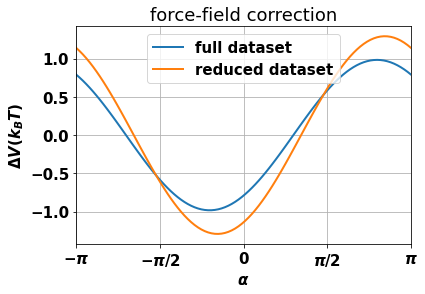

In [28]:
font = {'weight' : 'bold', 'size' : 15}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

phi = np.linspace(-np.pi, np.pi, 100)

pars_ff = df_result.loc['E+FM+FF ref'][['sin alpha', 'cos alpha']]
print('full dataset: ', pars_ff)
ff = pars_ff[0]*np.sin(phi) + pars_ff[1]*np.cos(phi)
plt.plot(phi, ff, label='full dataset')

pars_ff = df_result_nested.loc['E+FM+FF ref'][['sin alpha', 'cos alpha']]
print('\nreduced dataset: ', pars_ff)
ff = pars_ff[0]*np.sin(phi) + pars_ff[1]*np.cos(phi)
plt.plot(phi, ff, label='reduced dataset')

plt.title('force-field correction')
plt.xlabel(r'$\alpha$')
plt.ylabel('$\Delta V (k_B T)$')
plt.legend()
plt.xlim([-np.pi, np.pi])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.grid()

# plt.savefig('../../Figures/train_ff_correction.pdf', format='pdf', bbox_inches='tight')

In [29]:
def karplus_eqs(abc_vec, label = None):
    a = abc_vec[0]
    b = abc_vec[1]
    c = abc_vec[2]
    
    phi = np.linspace(-np.pi, np.pi, 100)
    jcoupl = a*np.cos(phi)**2 + b*np.cos(phi) + c
    if label is None: plt.plot(phi, jcoupl)
    else: plt.plot(phi, jcoupl, label=label)
    
    return phi, jcoupl

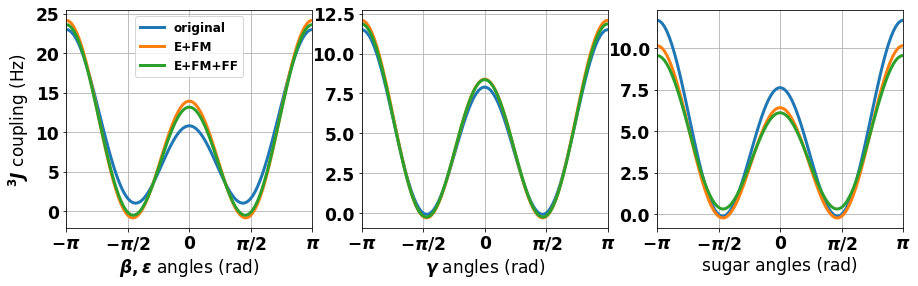

In [30]:
orig_karplus = {'A_gamma': 9.7, 'B_gamma': -1.8, 'C_gamma': 0.0, 'A_beta': 15.3, 'B_beta': -6.1, 'C_beta': 1.6, 'A_sugar': 9.67, 'B_sugar': -2.03, 'C_sugar': 0.}

font = {'weight' : 'bold', 'size' : 17}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 3
# matplotlib.rcParams['lines.markersize'] = 10

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4)
fig.set_figwidth(15)

compute_karplus = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

# plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)
titles = [r'$\beta,\epsilon$', r'$\gamma$', 'sugar']

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    karplus = {}

    karplus = compute_karplus(orig_karplus, angles, s)
    axs[i].plot(angles, karplus, '-', label='original')

    # whole dataset
    
    # karplus = compute_karplus(df_result.loc['E+FM ref'], angles, s)
    # axs[i].plot(angles, karplus, '-', label='whole, E+FM')

    # karplus = compute_karplus(df_result.loc['E+FM+FF ref'], angles, s)
    # axs[i].plot(angles, karplus, '-', label='whole, E+FM+FF')

    # reduced dataset

    karplus = compute_karplus(df_result_nested.loc['E+FM ref'], angles, s)
    axs[i].plot(angles, karplus, '-', label='E+FM')

    karplus = compute_karplus(df_result_nested.loc['E+FM+FF ref'], angles, s)
    axs[i].plot(angles, karplus, '-', label='E+FM+FF')
    
    axs[i].grid()
    axs[i].set_xlabel(titles[i] + ' angles (rad)')
    # axs[0].set_ylim(top=27)
    # axs[i].set_title(titles[i])
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend(fontsize=12)
axs[0].set_ylabel('$^3J$ coupling (Hz)')

# plt.savefig('../../Figures/train_Karplus_refinement.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [31]:
df_result_nested[['ref. test chi2', 'test chi2', 'ref. validation chi2', 'validation chi2']]


,ref. test chi2,test chi2,ref. validation chi2,validation chi2
E+FM ref,537.43525,1.620779,245.267645,0.884798
E+FM+FF ref,537.43525,2.129081,147.789435,1.335130
